## Tiểu luận 2 : Image Filters

In [2]:

import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim

# Hàm trợ giúp để hiển thị ảnh bằng Matplotlib
def display_images(images, titles, rows, cols):
    plt.figure(figsize=(15, 8))
    for i, (image, title) in enumerate(zip(images, titles)):
        plt.subplot(rows, cols, i + 1)
        # Chuyển từ BGR (OpenCV) sang RGB (Matplotlib) để hiển thị đúng màu
        if len(image.shape) == 3:
            plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
        else:
            plt.imshow(image, cmap='gray')
        plt.title(title)
        plt.axis('off')
    plt.tight_layout()
    plt.show()

# Hàm trợ giúp để vẽ histogram
def plot_histogram(image, title):
    plt.figure(figsize=(8, 5))
    color = ('b', 'g', 'r')
    for i, col in enumerate(color):
        # Tính histogram cho từng kênh màu
        hist = cv2.calcHist([image], [i], None, [256], [0, 256])
        plt.plot(hist, color=col)
        plt.xlim([0, 256])
    plt.title(title)
    plt.xlabel("Giá trị pixel")
    plt.ylabel("Số lượng")
    plt.show()

### Bài 1 – So sánh và phân tích các bộ lọc làm mờ

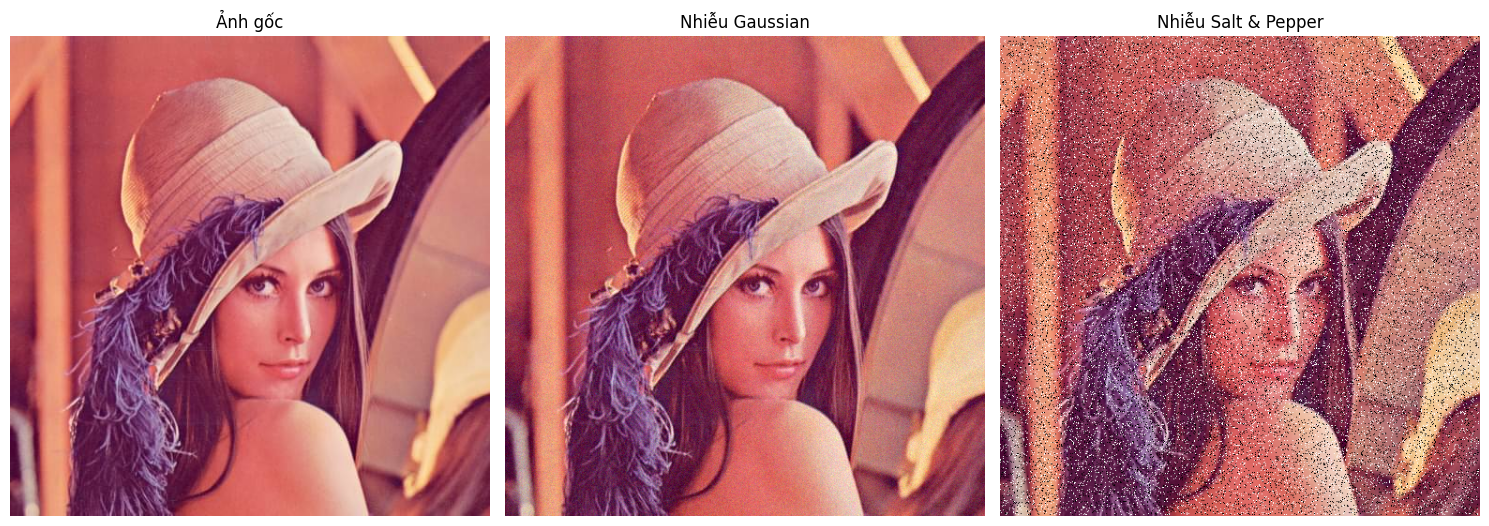

In [5]:
# Đọc ảnh gốc (điều chỉnh đường dẫn vì notebook trong thư mục notebooks/)
original_image = cv2.imread('../data/lena.jpg')

# Hàm thêm nhiễu Gaussian
def add_gaussian_noise(image):
    row, col, ch = image.shape
    mean = 0
    var = 100 # Phương sai càng lớn, nhiễu càng nhiều
    sigma = var ** 0.5
    gauss = np.random.normal(mean, sigma, (row, col, ch))
    gauss = gauss.reshape(row, col, ch)
    noisy = image + gauss
    # Chuyển về dải giá trị 0-255
    noisy = np.clip(noisy, 0, 255)
    return noisy.astype(np.uint8)

# Hàm thêm nhiễu Salt & Pepper
def add_salt_and_pepper_noise(image, amount=0.05):
    row, col, _ = image.shape
    s_vs_p = 0.5
    noisy = np.copy(image)
    # Salt
    num_salt = np.ceil(amount * image.size * s_vs_p)
    coords = [np.random.randint(0, i - 1, int(num_salt)) for i in image.shape]
    noisy[coords[0], coords[1], :] = 255

    # Pepper
    num_pepper = np.ceil(amount * image.size * (1. - s_vs_p))
    coords = [np.random.randint(0, i - 1, int(num_pepper)) for i in image.shape]
    noisy[coords[0], coords[1], :] = 0
    return noisy

# Tạo các ảnh nhiễu (chỉ khi ảnh được tải thành công)
if original_image is not None:
    gaussian_noisy_image = add_gaussian_noise(original_image)
    sp_noisy_image = add_salt_and_pepper_noise(original_image)

    # Hiển thị ảnh gốc và ảnh nhiễu
    display_images(
        [original_image, gaussian_noisy_image, sp_noisy_image],
        ["Ảnh gốc", "Nhiễu Gaussian", "Nhiễu Salt & Pepper"],
        1, 3
    )

NHIỄU GAUSSIAN


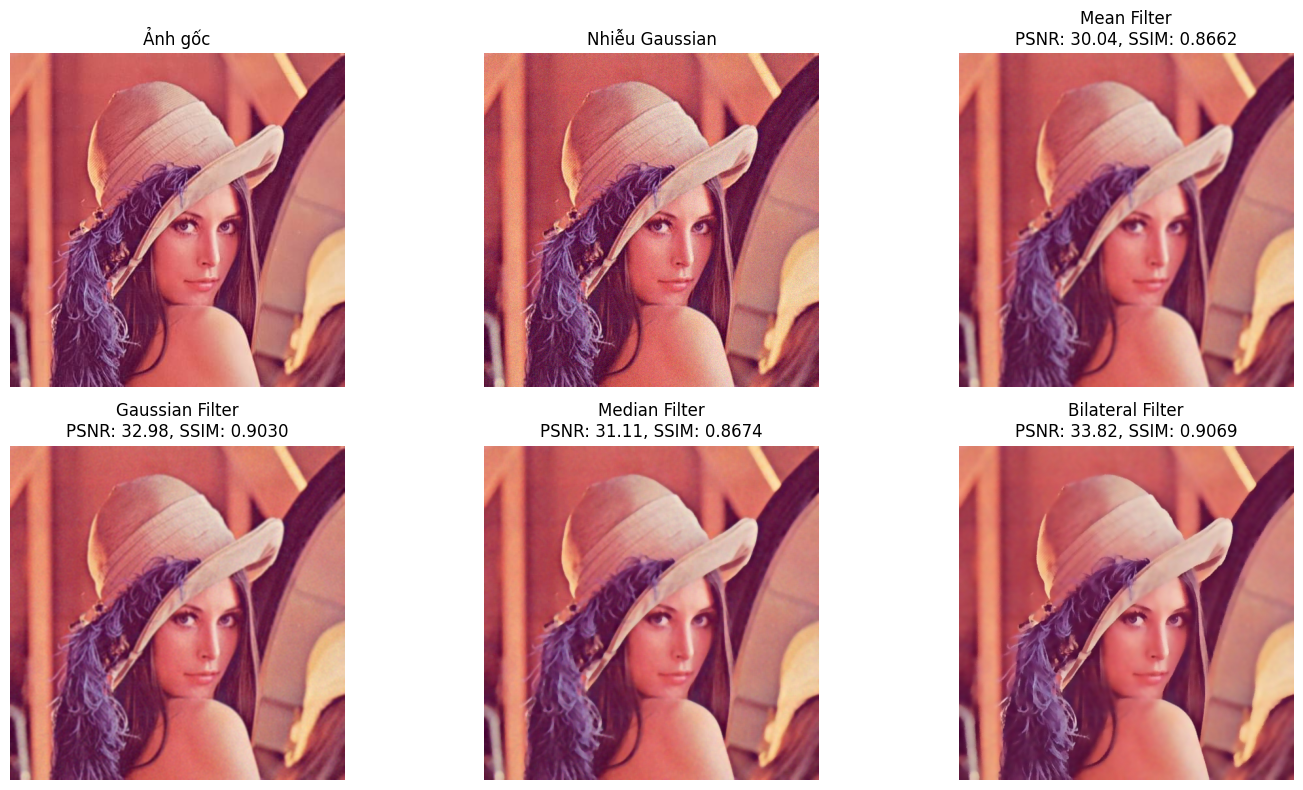

NHIỄU SALT & PEPPER


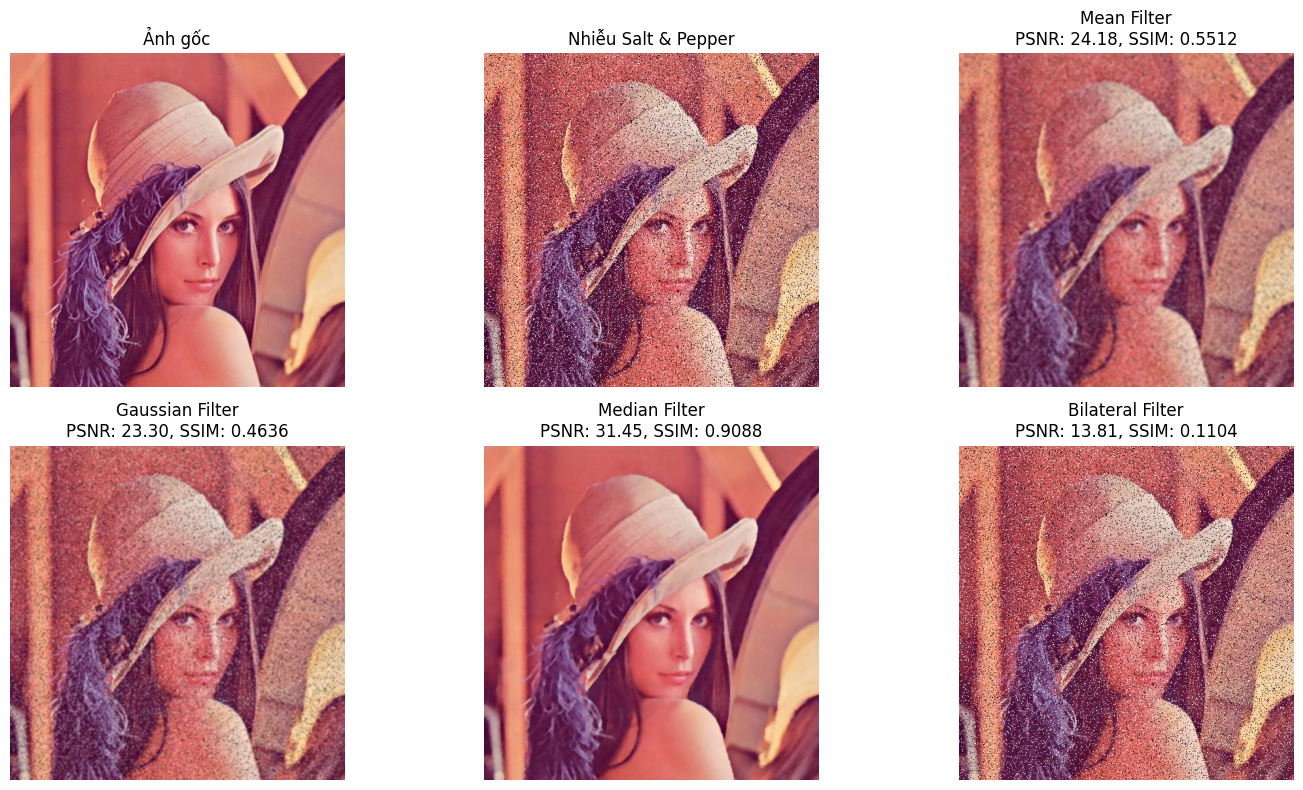

In [9]:
# Danh sách các bộ lọc và ảnh nhiễu để xử lý
filters = {
    "Mean Filter": lambda img: cv2.blur(img, (5, 5)),
    "Gaussian Filter": lambda img: cv2.GaussianBlur(img, (5, 5), 0),
    "Median Filter": lambda img: cv2.medianBlur(img, 5),
    "Bilateral Filter": lambda img: cv2.bilateralFilter(img, 9, 75, 75)
}

noisy_images = {
    "Nhiễu Gaussian": gaussian_noisy_image,
    "Nhiễu Salt & Pepper": sp_noisy_image
}

results = {}

# Vòng lặp qua các loại nhiễu
for noise_name, noisy_img in noisy_images.items():
    print(f"{noise_name.upper()}")
    filtered_imgs = []
    filtered_titles = []

    # Vòng lặp qua các bộ lọc
    for filter_name, filter_func in filters.items():
        # Áp dụng bộ lọc
        filtered_img = filter_func(noisy_img)

        # Tính toán PSNR và SSIM
        psnr_val = psnr(original_image, filtered_img, data_range=255)
        ssim_val = ssim(original_image, filtered_img, channel_axis=2, data_range=255)

        filtered_imgs.append(filtered_img)
        filtered_titles.append(f"{filter_name}\nPSNR: {psnr_val:.2f}, SSIM: {ssim_val:.4f}")

    # Hiển thị kết quả
    display_images(
        [original_image, noisy_img] + filtered_imgs,
        ["Ảnh gốc", noise_name] + filtered_titles,
        2, 3
    )




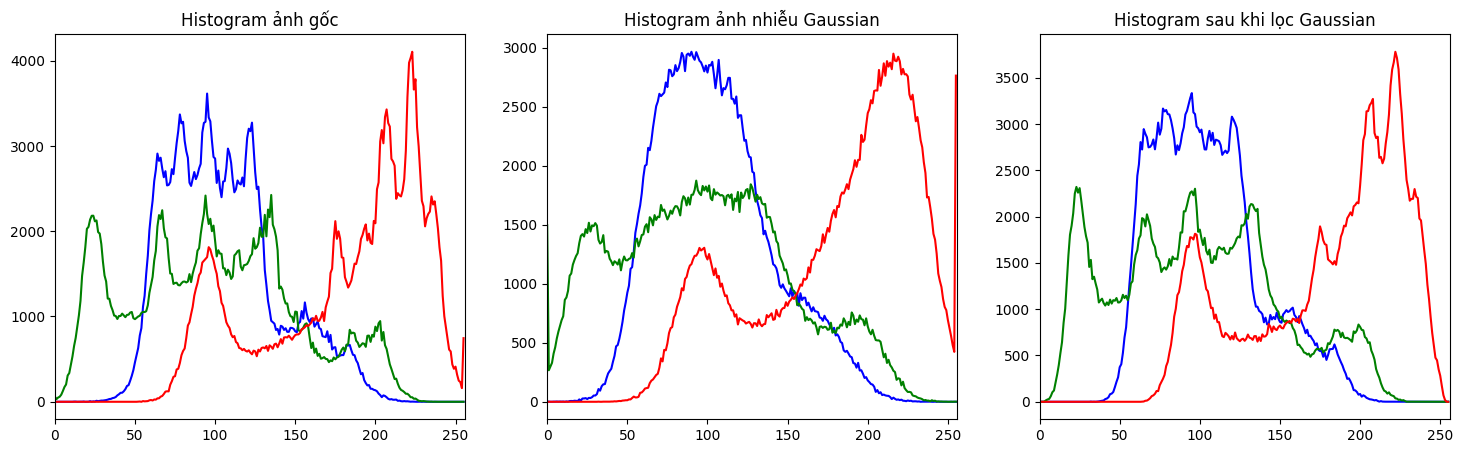

In [ ]:
# So sánh histogram trên cùng một hàng
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Hàm vẽ histogram cho subplot
def plot_histogram_subplot(image, title, ax):
    color = ('b', 'g', 'r')
    for i, col in enumerate(color):
        
        hist = cv2.calcHist([image], [i], None, [256], [0, 256])
        ax.plot(hist, color=col)
        ax.set_xlim([0, 256])
    ax.set_title(title)
    
# Vẽ 3 histogram
plot_histogram_subplot(original_image, "Histogram ảnh gốc", axes[0])
plot_histogram_subplot(gaussian_noisy_image, "Histogram ảnh nhiễu Gaussian", axes[1])
plot_histogram_subplot(cv2.GaussianBlur(gaussian_noisy_image, (5, 5), 0), "Histogram sau khi lọc Gaussian", axes[2])
plt.show()

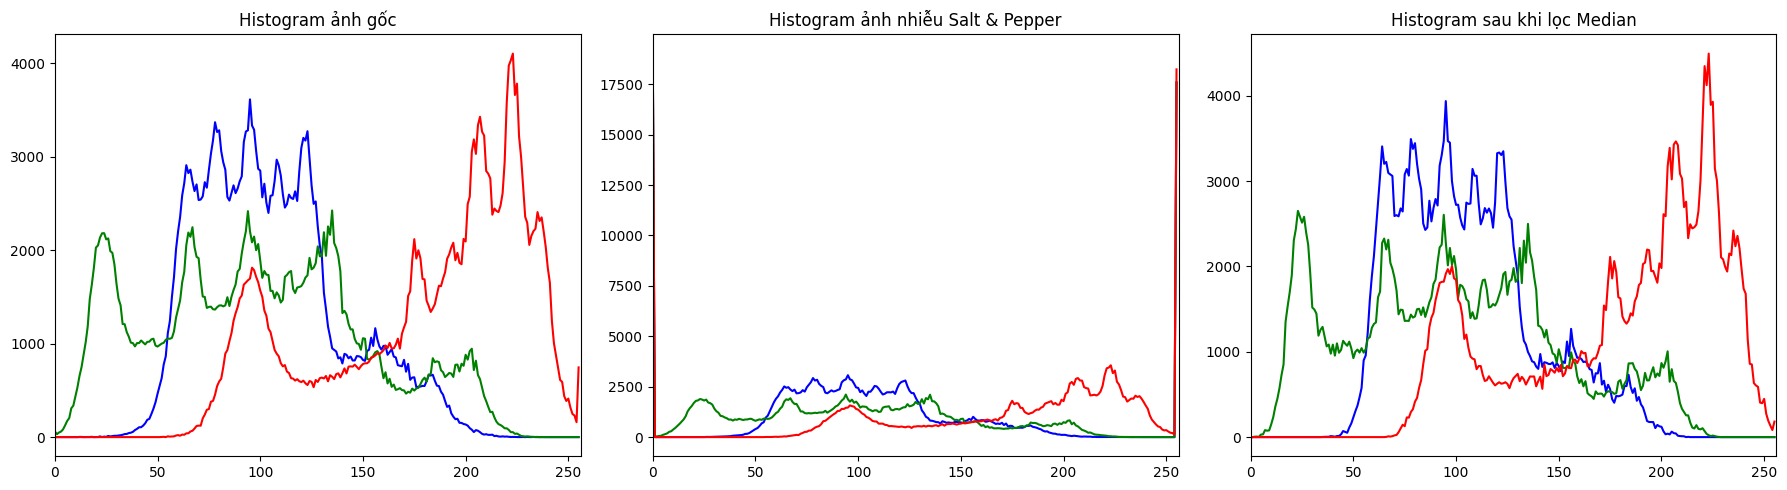

In [16]:
# So sánh histogram cho nhiễu Salt & Pepper
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Vẽ 3 histogram cho nhiễu Salt & Pepper
plot_histogram_subplot(original_image, "Histogram ảnh gốc", axes[0])
plot_histogram_subplot(sp_noisy_image, "Histogram ảnh nhiễu Salt & Pepper", axes[1])
plot_histogram_subplot(cv2.medianBlur(sp_noisy_image, 5), "Histogram sau khi lọc Median", axes[2])

plt.tight_layout()
plt.show()



### So sánh các bộ lọc làm mờ ảnh

#### **Bộ lọc Mean và Gaussian (Tuyến tính)**
- **Ưu điểm:**  
    - Hiệu quả trong việc làm mờ và giảm nhiễu Gaussian.
    - Lấy trung bình (có trọng số hoặc không) của các pixel lân cận, làm "phẳng" các biến đổi đột ngột do nhiễu Gaussian gây ra.
- **Nhược điểm:**  
    - Làm mờ cả các cạnh và chi tiết quan trọng của ảnh.
    - Không hiệu quả với nhiễu Salt & Pepper vì các pixel trắng (255) và đen (0) làm lệch giá trị trung bình.

---

#### **Bộ lọc Median (Phi tuyến tính)**
- **Ưu điểm:**  
    - Cực kỳ hiệu quả với nhiễu Salt & Pepper.
    - Loại bỏ hoàn toàn các pixel nhiễu có giá trị cực đoan (0 hoặc 255) bằng cách lấy giá trị trung vị.
    - Bảo toàn các cạnh tốt hơn so với bộ lọc Mean/Gaussian.
- **Nhược điểm:**  
    - Có thể làm mất các chi tiết nhỏ, mỏng.
    - Ít hiệu quả hơn với nhiễu Gaussian so với các bộ lọc tuyến tính.

---

#### **Bộ lọc Bilateral (Phi tuyến tính)**
- **Ưu điểm:**  
    - Là bộ lọc "thông minh" nhất: vừa làm mịn các vùng có màu sắc tương đồng, vừa giữ lại các cạnh sắc nét.
    - Xem xét cả khoảng cách không gian và sự khác biệt về cường độ pixel.
    - Cho kết quả tốt trên cả nhiễu Gaussian mà vẫn giữ được chi tiết.
- **Nhược điểm:**  
    - Chậm hơn đáng kể so với các bộ lọc khác do tính toán phức tạp hơn.

---

#### **Kết luận**
- **PSNR** (càng cao càng tốt) và **SSIM** (càng gần 1 càng tốt) xác nhận các nhận xét trên:
    - **Median** cho kết quả tốt nhất trên nhiễu Salt & Pepper.
    - **Gaussian** và **Bilateral** hoạt động tốt trên nhiễu Gaussian.

### Bài 2 – Phát hiện cạnh (Edge Detection)

Ảnh được tải thành công với kích thước: (512, 512)


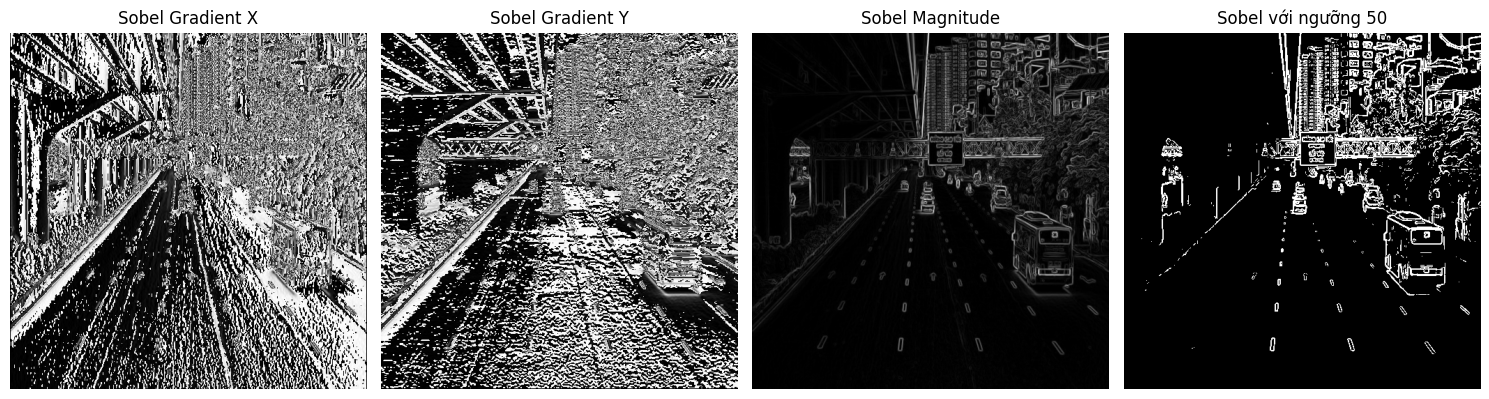

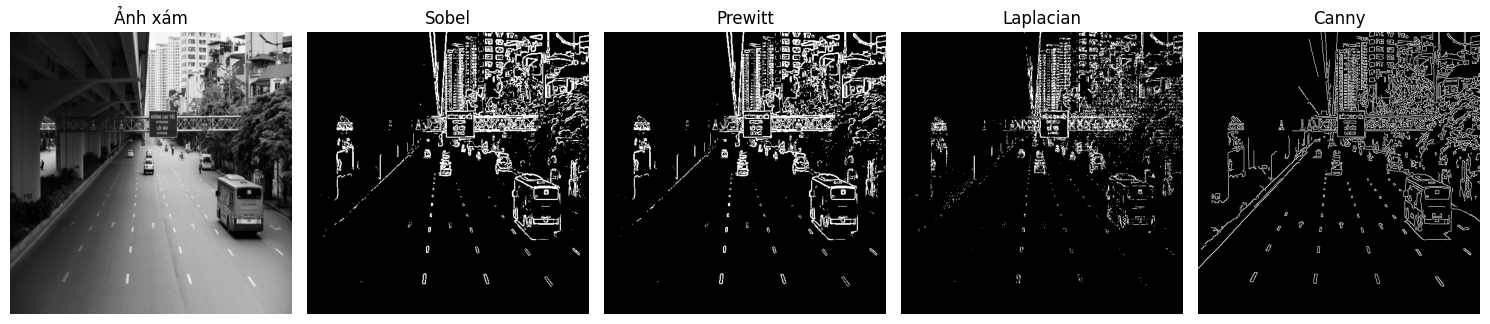

In [8]:
# Tải ảnh và chuyển sang ảnh xám (sử dụng đường dẫn tương đối)
edge_image = cv2.imread('C:\\Users\\tritv\\Documents\\IUH\\Image Processing\\tieu_luan_2\\data\\duongpho.jpg')
if edge_image is not None:
    edge_image = cv2.resize(edge_image, (512, 512))
    gray_image = cv2.cvtColor(edge_image, cv2.COLOR_BGR2GRAY)
    print(f"Ảnh được tải thành công với kích thước: {gray_image.shape}")
else:
    print("Không thể tải ảnh!")
    gray_image = np.zeros((512, 512), dtype=np.uint8)
    cv2.putText(gray_image, 'Image not found!', (100, 256), cv2.FONT_HERSHEY_SIMPLEX, 1, 255, 2)

# --- 1. Bộ lọc Sobel ---
# Định nghĩa kernel Sobel
sobel_x = np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]], dtype=np.float32)
sobel_y = np.array([[-1, -2, -1], [0, 0, 0], [1, 2, 1]], dtype=np.float32)

# Áp dụng tích chập
sobel_grad_x = cv2.filter2D(gray_image, cv2.CV_32F, sobel_x)
sobel_grad_y = cv2.filter2D(gray_image, cv2.CV_32F, sobel_y)

# Tính toán độ lớn gradient
sobel_magnitude = np.sqrt(sobel_grad_x**2 + sobel_grad_y**2)

# Chuyển đổi và chuẩn hóa an toàn
sobel_magnitude = np.clip(sobel_magnitude, 0, None)  # Đảm bảo không có giá trị âm
sobel_magnitude = (sobel_magnitude / sobel_magnitude.max() * 255).astype(np.uint8)

# Phân ngưỡng
_, sobel_thresh = cv2.threshold(sobel_magnitude, 50, 255, cv2.THRESH_BINARY)

# --- 2. Bộ lọc Prewitt ---
# Định nghĩa kernel Prewitt
prewitt_x = np.array([[-1, 0, 1], [-1, 0, 1], [-1, 0, 1]], dtype=np.float32)
prewitt_y = np.array([[-1, -1, -1], [0, 0, 0], [1, 1, 1]], dtype=np.float32)

# Áp dụng
prewitt_grad_x = cv2.filter2D(gray_image, cv2.CV_32F, prewitt_x)
prewitt_grad_y = cv2.filter2D(gray_image, cv2.CV_32F, prewitt_y)
prewitt_magnitude = np.sqrt(prewitt_grad_x**2 + prewitt_grad_y**2)

# Chuẩn hóa an toàn
prewitt_magnitude = np.clip(prewitt_magnitude, 0, None)
prewitt_magnitude = (prewitt_magnitude / prewitt_magnitude.max() * 255).astype(np.uint8)
_, prewitt_thresh = cv2.threshold(prewitt_magnitude, 50, 255, cv2.THRESH_BINARY)

# --- 3. Bộ lọc Laplacian ---
# Định nghĩa kernel Laplacian
laplacian_kernel = np.array([[0, 1, 0], [1, -4, 1], [0, 1, 0]], dtype=np.float32)
laplacian_output = cv2.filter2D(gray_image, cv2.CV_32F, laplacian_kernel)
laplacian_output = np.abs(laplacian_output)  # Lấy giá trị tuyệt đối
laplacian_output = (laplacian_output / laplacian_output.max() * 255).astype(np.uint8)
_, laplacian_thresh = cv2.threshold(laplacian_output, 30, 255, cv2.THRESH_BINARY)

# --- 4. So sánh với Canny (dùng hàm có sẵn) ---
canny_output = cv2.Canny(gray_image, 100, 200)

# Hiển thị các bước của Sobel
display_images(
    [sobel_grad_x.astype(np.uint8), sobel_grad_y.astype(np.uint8), sobel_magnitude, sobel_thresh],
    ["Sobel Gradient X", "Sobel Gradient Y", "Sobel Magnitude", "Sobel với ngưỡng 50"],
    1, 4
)

# So sánh tất cả các bộ lọc
display_images(
    [gray_image, sobel_thresh, prewitt_thresh, laplacian_thresh, canny_output],
    ["Ảnh xám", "Sobel", "Prewitt", "Laplacian", "Canny"],
    1, 5
)

### Độ nhạy của tham số ngưỡng:
Trong các bộ lọc Sobel, Prewitt, và Laplacian, việc chọn ngưỡng (threshold) rất quan trọng.

- Ngưỡng quá thấp: Sẽ giữ lại nhiều điểm nhiễu, làm kết quả bị "rác".

- Ngưỡng quá cao: Có thể làm mất đi các cạnh yếu, gây đứt gãy.
Canny giải quyết vấn đề này tốt hơn bằng cách sử dụng hai ngưỡng (thấp và cao) để cải thiện tính liên tục của cạnh.

### Bài 3 – Tăng cường ảnh (Image Enhancement)

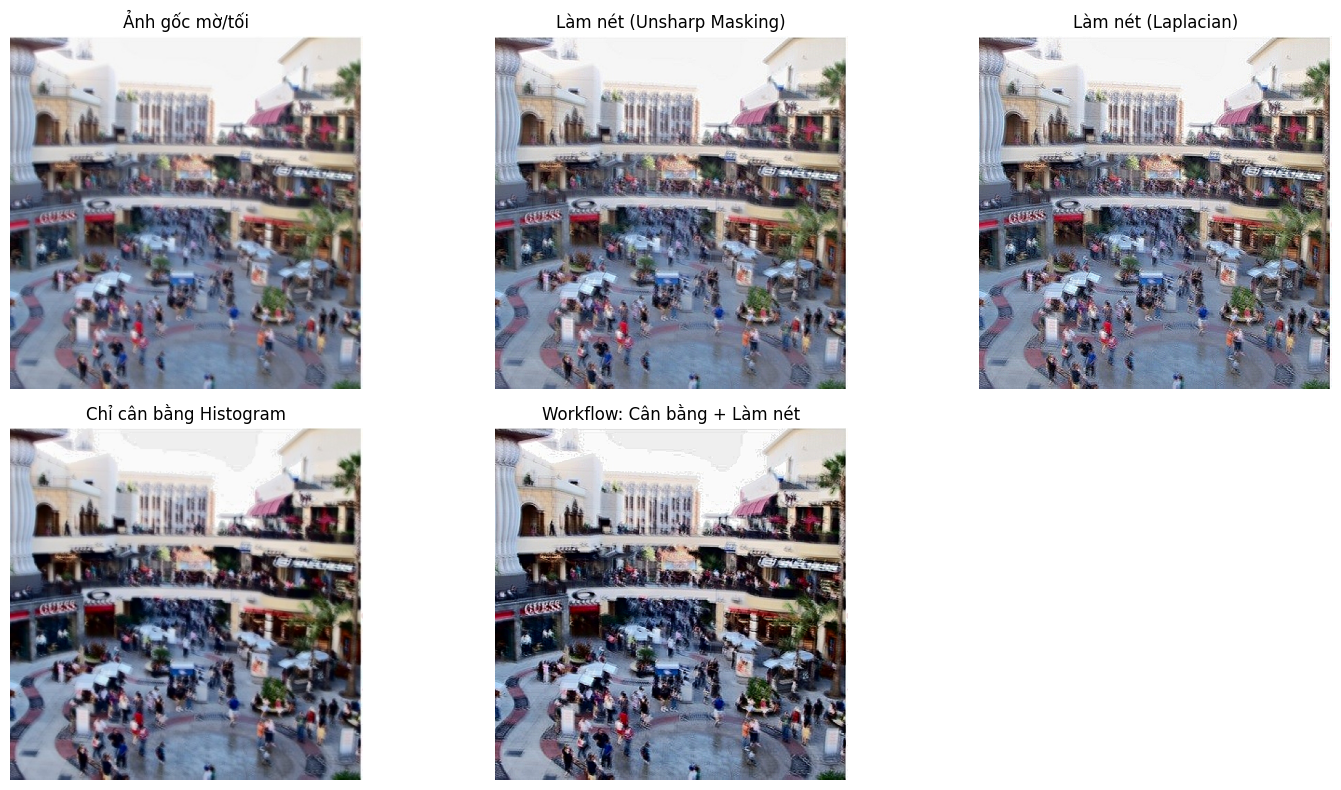

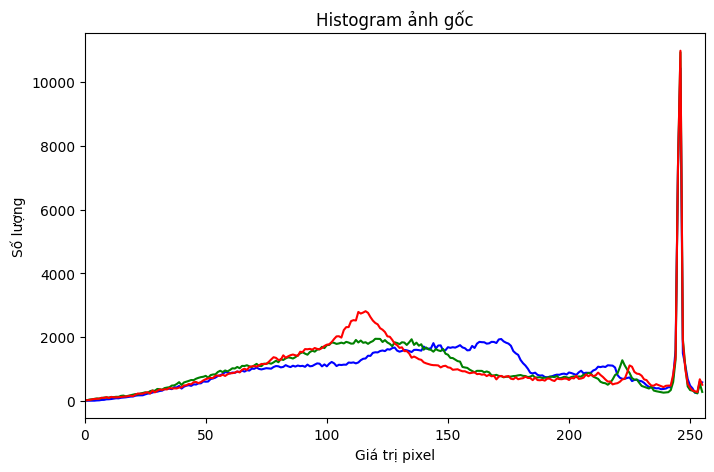

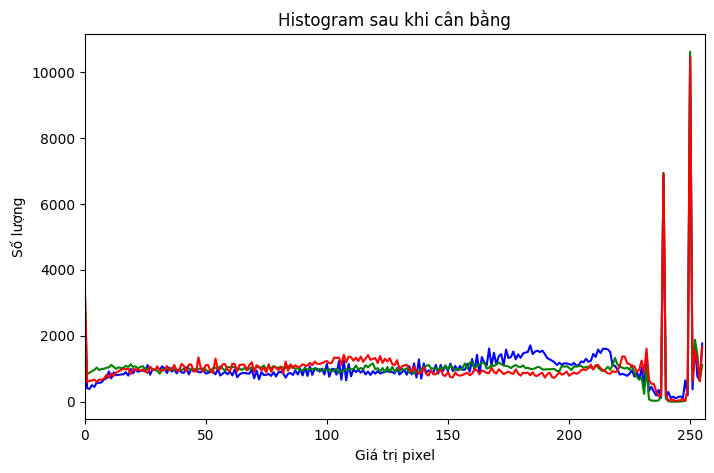

In [3]:
# Tải ảnh mờ hoặc thiếu sáng
try:
    blurry_image = cv2.imread('../data/mo4.jpg') # Thay thế bằng ảnh của bạn
    blurry_image = cv2.resize(blurry_image, (512, 512))
except:
    print("Không tìm thấy ảnh, tạo ảnh mờ mẫu.")
    # Cần một ảnh mẫu để chạy, nếu không có 'mo4.jpg' thì dùng 'lena.jpg'
    sample_img = cv2.imread('../data/lena.jpg')
    sample_img = cv2.resize(sample_img, (512, 512))
    blurry_image = cv2.GaussianBlur(sample_img, (15, 15), 0)

# --- 1. Kỹ thuật Unsharp Masking ---
# Tạo phiên bản mờ của ảnh
blurred = cv2.GaussianBlur(blurry_image, (5, 5), 0)

# Tạo mặt nạ "unsharp" bằng cách lấy ảnh gốc trừ đi ảnh mờ
# cv2.addWeighted cho phép cộng hai ảnh với trọng số
# Sharpened = Original * (1 + alpha) + Blurred * (-alpha)
alpha = 1.5
unsharp_masked = cv2.addWeighted(blurry_image, 1 + alpha, blurred, -alpha, 0)

# --- 2. Kỹ thuật làm nét bằng Laplacian ---
# Kernel Laplacian để làm nét (kết hợp kernel gốc và kernel trừ)
laplacian_kernel = np.array([[0, -1, 0], [-1, 5, -1], [0, -1, 0]], dtype=np.float32)
laplacian_sharpened = cv2.filter2D(blurry_image, -1, laplacian_kernel)


# --- 3. Kết hợp với Histogram Equalization ---
# Chuyển sang không gian màu YCrCb để chỉ cân bằng độ sáng (kênh Y)
ycrcb_img = cv2.cvtColor(blurry_image, cv2.COLOR_BGR2YCrCb)
# Cân bằng kênh Y
ycrcb_img[:, :, 0] = cv2.equalizeHist(ycrcb_img[:, :, 0])
# Chuyển về lại BGR
hist_eq_image = cv2.cvtColor(ycrcb_img, cv2.COLOR_YCrCb2BGR)


# --- 4. Đề xuất workflow: Cân bằng Histogram TRƯỚC, làm nét SAU ---
ycrcb_img_workflow = cv2.cvtColor(blurry_image, cv2.COLOR_BGR2YCrCb)
ycrcb_img_workflow[:, :, 0] = cv2.equalizeHist(ycrcb_img_workflow[:, :, 0])
hist_eq_for_workflow = cv2.cvtColor(ycrcb_img_workflow, cv2.COLOR_YCrCb2BGR)

# Áp dụng unsharp masking lên ảnh đã cân bằng histogram
blurred_workflow = cv2.GaussianBlur(hist_eq_for_workflow, (5, 5), 0)
final_result = cv2.addWeighted(hist_eq_for_workflow, 1 + alpha, blurred_workflow, -alpha, 0)


# Hiển thị kết quả
display_images(
    [blurry_image, unsharp_masked, laplacian_sharpened, hist_eq_image, final_result],
    ["Ảnh gốc mờ/tối", "Làm nét (Unsharp Masking)", "Làm nét (Laplacian)", "Chỉ cân bằng Histogram", "Workflow: Cân bằng + Làm nét"],
    2, 3
)

# Hiển thị histogram để minh họa
plot_histogram(blurry_image, "Histogram ảnh gốc")
plot_histogram(hist_eq_image, "Histogram sau khi cân bằng")

#### Tại sao kết hợp filter + histogram equalization hiệu quả?

**Histogram Equalization (Cân bằng lược đồ xám):**  
Bước này xử lý vấn đề về tương phản toàn cục (global contrast). Nó kéo dài dải cường độ của ảnh, làm cho các vùng tối trở nên tối hơn và các vùng sáng trở nên sáng hơn, tận dụng toàn bộ dải giá trị pixel có thể. Nhờ đó, nhiều chi tiết bị ẩn trong vùng tối hoặc sáng được làm rõ hơn.

**Sharpening Filter (Làm sắc nét):**  
Sau khi các chi tiết đã được làm rõ nhờ cân bằng histogram, bộ lọc làm nét sẽ tăng cường tương phản cục bộ (local contrast), làm nổi bật các cạnh và đường viền, giúp chi tiết trở nên sắc nét hơn.

**Kết hợp cả hai:**  
- Histogram equalization giúp "mở khóa" các chi tiết bị ẩn do thiếu tương phản.
- Filter làm nét nhấn mạnh các chi tiết này, đặc biệt là tại các cạnh.
- Workflow: Cân bằng histogram trước, sau đó làm nét sẽ cho kết quả tối ưu về cả độ tương phản tổng thể lẫn độ sắc nét chi tiết.

### Bài 4 – Bộ lọc trong xử lý ảnh y tế

Ảnh y tế được tải thành công với kích thước: (512, 512)


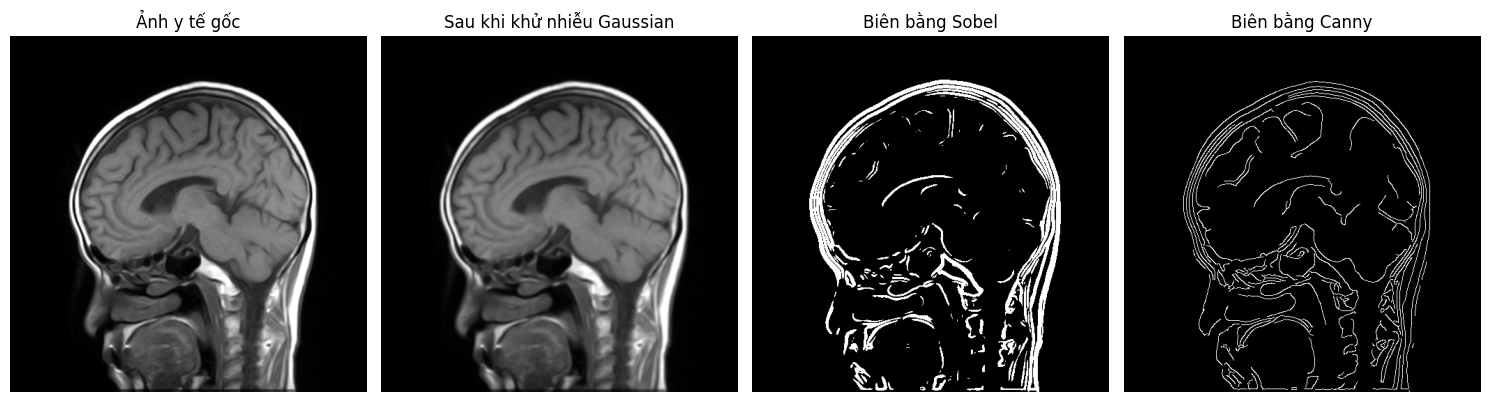

In [22]:
# Tải ảnh y tế và chuyển sang ảnh xám
try:
    medical_image = cv2.imread('C:\\Users\\tritv\\Documents\\IUH\\Image Processing\\tieu_luan_2\\data\\MRI_brain.jpg') 
    medical_image = cv2.resize(medical_image, (512, 512))
    medical_gray = cv2.cvtColor(medical_image, cv2.COLOR_BGR2GRAY)
    print(f"Ảnh y tế được tải thành công với kích thước: {medical_gray.shape}")
except Exception as e:
    print(f"Lỗi khi tải ảnh: {e}")
    medical_gray = np.zeros((512, 512), dtype=np.uint8)
    cv2.putText(medical_gray, 'Medical image not found!', (50, 256), cv2.FONT_HERSHEY_SIMPLEX, 1, 255, 2)

# --- 1. Áp dụng Gaussian smoothing để khử nhiễu ---
# Ảnh y tế thường có nhiễu, việc làm mịn là bước tiền xử lý quan trọng
smoothed_medical = cv2.GaussianBlur(medical_gray, (5, 5), 0)

# --- 2. Áp dụng Sobel/Canny để phát hiện biên ---
# Áp dụng trên ảnh ĐÃ được làm mịn
sobel_x_med = cv2.filter2D(smoothed_medical, cv2.CV_32F, sobel_x)
sobel_y_med = cv2.filter2D(smoothed_medical, cv2.CV_32F, sobel_y)

# Tính toán độ lớn gradient với cách xử lý an toàn
sobel_magnitude_med = np.sqrt(sobel_x_med**2 + sobel_y_med**2)

# Chuẩn hóa an toàn
sobel_magnitude_med = np.clip(sobel_magnitude_med, 0, None)  # Đảm bảo không có giá trị âm
if sobel_magnitude_med.max() > 0:  # Tránh chia cho 0
    sobel_magnitude_med = (sobel_magnitude_med / sobel_magnitude_med.max() * 255).astype(np.uint8)
else:
    sobel_magnitude_med = sobel_magnitude_med.astype(np.uint8)

# Phân ngưỡng
_, sobel_thresh_med = cv2.threshold(sobel_magnitude_med, 40, 255, cv2.THRESH_BINARY)

# Canny cho kết quả tốt hơn
canny_med = cv2.Canny(smoothed_medical, 50, 150)

# Hiển thị kết quả
display_images(
    [medical_gray, smoothed_medical, sobel_thresh_med, canny_med],
    ["Ảnh y tế gốc", "Sau khi khử nhiễu Gaussian", "Biên bằng Sobel", "Biên bằng Canny"],
    1, 4
)

### Nhận xét

**Ảnh minh họa trước/sau lọc:**  
Các hình ảnh trên cho thấy rõ sự khác biệt. Ảnh gốc có thể chứa nhiễu làm cho các đường biên không rõ ràng. Sau khi lọc Gaussian, ảnh trở nên mượt hơn, giúp các thuật toán phát hiện cạnh hoạt động chính xác hơn. Kết quả từ Canny trên ảnh đã được làm mịn cho thấy đường biên của các cấu trúc (ví dụ: xương, khối u) rõ nét và liên tục hơn nhiều so với Sobel.

**Độ rõ nét của vùng biên:**

- **Ưu điểm:**  
    - Các bộ lọc là công cụ cơ bản và thiết yếu trong tiền xử lý ảnh y tế.
    - *Gaussian Smoothing*: Giảm nhiễu hiệu quả, là bước bắt buộc trước khi phân tích sâu hơn như phát hiện cạnh hay phân vùng (segmentation). Nếu không có bước này, thuật toán phát hiện cạnh sẽ cho ra rất nhiều "cạnh giả" do nhiễu.
    - *Sobel/Canny*: Giúp tự động hóa việc xác định ranh giới của các cơ quan hoặc các vùng tổn thương. Đây là bước đầu tiên để các bác sĩ hoặc hệ thống AI có thể đo lường kích thước, hình dạng của một khối u hoặc một cấu trúc giải phẫu.

- **Nhược điểm:**  
    - *Mất chi tiết*: Lọc Gaussian quá mạnh (kernel size hoặc sigma lớn) có thể làm mờ cả những chi tiết nhỏ nhưng quan trọng về mặt y khoa.
    - *Độ nhạy tham số*: Hiệu quả của Canny phụ thuộc rất nhiều vào việc chọn ngưỡng. Một ngưỡng không phù hợp có thể dẫn đến việc bỏ sót các vùng biên có độ tương phản thấp hoặc tạo ra các đường biên không liên tục.
    - *Không đủ thông minh*: Các bộ lọc cổ điển này chỉ hoạt động dựa trên cường độ pixel. Chúng không có "kiến thức" về giải phẫu. Do đó, trong nhiều trường hợp phức tạp, chúng không thể phân biệt được đâu là ranh giới của một khối u và đâu là ranh giới của một mô bình thường chồng lên nó. Các phương pháp học sâu (Deep Learning) hiện đại thường cho kết quả vượt trội trong các tác vụ phân vùng ảnh y tế.
